In [3]:
import compute_charge_dist as fz
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

import PeHeat_Functions as peh
import parametric_fz as fzpar
import dust_size_dist as sizedist

from matplotlib.colors import LogNorm

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import MCMCFit as mcmc

%matplotlib inline

microntocm    = 1.0e-4
cmtomicron    = 1.0e4
AAtocm        = 1.0e-8
cmtoAA        = 1.0e8
microntoAA    = 1.0e4
AAtomicron    = 1.0e-4
ergtoeV       = 6.242e11
eVtoerg       = 1.602e-12

hplanck       = 4.135667662e-15 # eV s
clight        = 2.99792458e10   # cm s-1

Loading the library to compute the charge distribution of dust grains.


In [4]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [5]:
# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
#data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

Geff = 1.7 * np.exp(-2.5*box["cdto"])

yt : [INFO     ] 2018-11-30 18:47:05,430 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-11-30 18:47:05,436 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-30 18:47:05,436 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-30 18:47:05,437 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-30 18:47:05,438 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-30 18:47:05,457 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-11-30 18:47:05,458 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-11-30 18:47:05,459 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-11-30 18:47:05,460 Parameters: domain_righ

In [6]:
np.random.seed(1)
#np.random.seed(2)
ncells = len(box["nH"])
percent = 10.0
ncells         = len(box["nH"])
n5             = np.int(ncells * percent/100.)
rand_index     = np.random.randint(0, ncells, n5)

In [7]:
temp = np.array(box["temp"][rand_index])
dd   = np.array(box["dens"][rand_index])
nH   = np.array(box["nH"]  [rand_index])
nH2  = np.array(box["nH2"] [rand_index])
nC   = np.array(box["nC"]  [rand_index])
ne   = np.array(box["ne"]  [rand_index])
xe   = np.array(box["xe"]  [rand_index])
xHp  = np.array(box["xHp"] [rand_index])
xH2  = np.array(box["xH2"] [rand_index])
xCp  = np.array(box["xCp"] [rand_index])
Av   = np.array(box["cdto"][rand_index])
fH2shield = np.array(box["cdh2"][rand_index])

Ntot = Av * 1.87e21
Geff = 1.7 * np.exp(-2.5*Av)

In [8]:
NH2 = np.zeros_like(Av)
G_CR = np.zeros_like(Av)

for ii in range(len(Av)):
    NH2[ii]   = fz.get_NH2(fH2shield[ii], temp[ii])
    G_CR[ii]  = fz.get_G_CR(NH2[ii])

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/pynverse/inverse.py:196: RuntimeWarning: Results obtained with less than 2 decimal digits of accuracy
  % accuracy, RuntimeWarning)


In [9]:
zeta = np.zeros_like(NH2)
new_ne = np.zeros_like(NH2)
new_xe = np.zeros_like(NH2)
for i in range(len(zeta)):
    zeta[i]  = fz.get_zeta(NH2[i])
    new_ne[i], new_xe[i] = fz.compute_new_xe([nH[i], 0.], [xe[i],0], xH2[i], zeta[i])

In [10]:
Gtot = Geff + G_CR

In [11]:
def get_epsilon(psi, temp):
    ephere = 0.049 / (1. + (psi/963.)**(0.73)) + 0.037*(temp/1.0e4)/(1.+(psi/2500.))
    return ephere

def Gamma_BT94(ntot, Geff, temp, ne):
    psi     = Geff * np.sqrt(temp) / ne
    epsilon = get_epsilon(psi, temp)
    Gammahere = 1.3e-24 * epsilon * Geff * ntot
    return Gammahere

In [12]:
Heat_BT94 = Gamma_BT94(nH, Geff, temp, ne)
Heat_BT94Upd = Gamma_BT94(nH, Gtot, temp, new_ne)

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


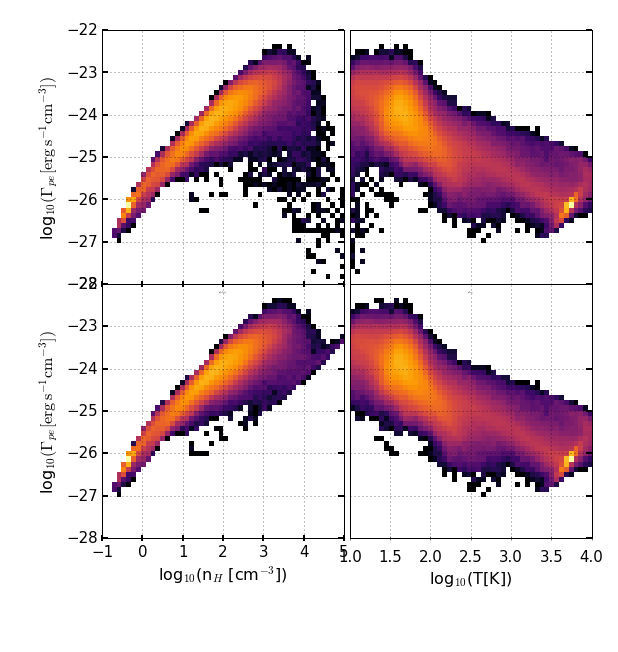

In [13]:
xsize = 8
ysize = 8.6

nfigs_x = 2
nfigs_y = 2

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.15
wpad = 0.13
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

##########################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(nH), np.log10(Heat_BT94Upd), bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 5.0],[-28, -22]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("log$_{10} (\Gamma_{pe}[\mathrm{erg \, s}^{-1} \mathrm{cm}^{-3}])$", fontsize=16)
ax.set_xlabel("log$_{10}$(n$_{H}$ [cm$^{-3}$])", fontsize=16)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(temp), np.log10(Heat_BT94Upd), bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[-28, -22]])

ax.grid("on")

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', labelsize=15)
#ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)

ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(T[K])", fontsize=16)

ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 1

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(nH), np.log10(Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 5.0],[-28, -22]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("log$_{10} (\Gamma_{pe}[\mathrm{erg \, s}^{-1} \mathrm{cm}^{-3}])$", fontsize=16)
ax.set_xlabel("log$_{10}$(n$_{H}$ [cm$^{-3}$])", fontsize=0)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='off')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 1

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(temp), np.log10(Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[-28, -22]])

ax.grid("on")

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='off', labelsize=15)
ax.tick_params(axis='x', which='both', bottom='off', top='off', direction= 'inout',labelbottom='off') # labels along the bottom edge are off
ax.set_xlabel("log$_{10}$(T[K])", fontsize=0)
ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

#fig.savefig("/Users/juan/Dropbox/Talks/Conf, Workshops & Schools/2018/Group Meeting/BT94_heating_UpdatedGtotne.pdf", format="pdf")

fig.show()


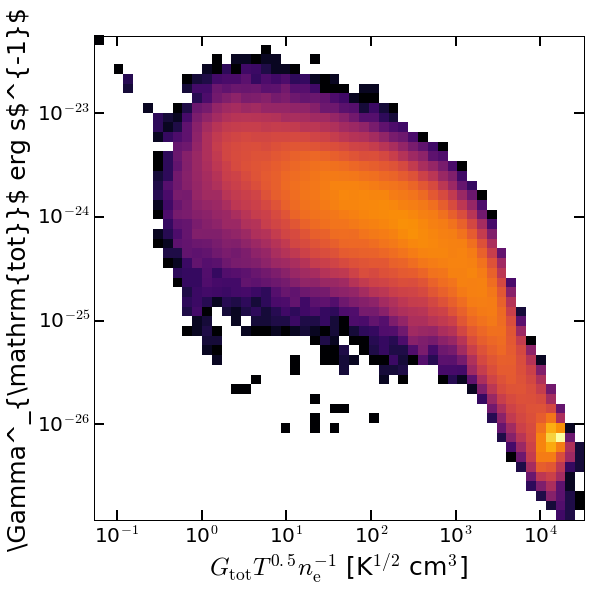

In [15]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_axes([0.14, 0.11, 0.85, 0.84])

from matplotlib.ticker import MaxNLocator
def format_func(value, tick_number):
    return "10$^{%i}$"%value


GTn = (Gtot)*np.sqrt(temp)/new_ne

ax.hist2d(np.log10(GTn), np.log10(Heat_BT94Upd), bins=50, norm=LogNorm(), cmap="inferno")

#ax.set_ylabel("T [K]", fontsize=25)
#
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")


#ax.set_ylim(-0.9, 4.99)
ax.set_ylabel("\Gamma^_{\\mathrm{tot}}$ erg s$^{-1}$", fontsize=25)
ax.set_xlabel("$G_{\mathrm{tot}}T^{0.5} n_{\\mathrm{e}}^{-1}$ [K$^{1/2}$ cm$^{3}$]", fontsize=25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#ax.set_yscale("log")

#ax.set_xlim(np.log10(np.min(cdist["nH"])), 4.5)
#fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/PeHeat_dust/Figures/Figure_6_TotalHeating_GTn.pdf", format="pdf")


fig.show()

---

In [12]:
#zeta = np.zeros_like(NH2)
#new_ne = np.zeros_like(NH2)
#new_xe = np.zeros_like(NH2)
#for i in range(len(zeta)):
#    zeta[i]  = fz.get_zeta(NH2[i])
#    new_ne[i], new_xe[i] = fz.compute_new_xe([nH[i], 0.], [xe[i],0], xH2[i], zeta[i])

In [13]:
#Gtot = Geff + G_CR

In [14]:
def get_Gamma_dotdot_par_old(asize, G, Z, grain_type):
    """
    Parametric equation of the energy per photoelectron as a function of the grain size, charge, strength of the incident radiation field and charge.
    
    Input parameters:
        asize: Grain size in Angstroms
        G: Scaling of the radiation field in units of Habing field.
        Z: Charge, in units of proton charge.
        grain_type: 'silicate' or 'carbonaceous'
        
    return:
        Gamma_pe^{''} in erg s-1
    """
    
    if grain_type == "silicate":
        Gamma0 = 2.3e-20
        alpha  = 2.39
        zeta   = 2.953042 * (asize / 5.0)**(-1.03848) 
    else:
        
        Gamma0 = 4.06768782673e-20
        alpha  = 2.16393168
        zeta   = 0.9935858817946079 * (asize / 5.0)**(-1.04665779) 
    
    gamma_dotdot_pe = Gamma0 * (asize / 5.0)**(alpha) * (G / 1.7) * np.exp(- zeta * Z)
    
    return gamma_dotdot_pe

def pwse_size(x, x0, y0, k1, k2):
    piecewisehere = np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0, lambda x:k2*x + y0-k2*x0+k1*x0])
    return 10**(piecewisehere)

def get_Gamma_dotdot_par(asize, G, Z, grain_type):
    """
    Parametric equation of the energy per photoelectron as a function of the grain size, charge, strength of the incident radiation field and charge.
    
    Input parameters:
        asize: Grain size in Angstroms
        G: Scaling of the radiation field in units of Habing field.
        Z: Charge, in units of proton charge.
        grain_type: 'silicate' or 'carbonaceous'
        
    return:
        Gamma_pe^{''} in erg s-1
    """
    
    def pwse_size(x, x0, y0, k1, k2):
        piecewisehere = np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0, lambda x:k2*x + y0-k2*x0+k1*x0])
        return 10**(piecewisehere)
        
    if grain_type == "silicate":
        Gamma0  = 7.19e-21
        alpha1  = 3.2
        alpha2  = 1.7
        abreak  = np.log10(79.)
        zeta    = 2.95 * (asize / 5.0)**(-1.04) 
    else:
        
        Gamma0  = 1.98e-20
        alpha1  = 2.6
        alpha2  = 1.6
        abreak  = np.log10(159.)
        zeta    = 0.99 * (asize / 5.0)**(-1.05) 
    
    l5 = np.log10(5.0)
    lG0 = np.log10(Gamma0)
    
    gamma_dotdot_pe = pwse_size(np.log10(asize)-l5,abreak-l5, lG0, alpha1, alpha2) * (G / 1.7) * np.exp(- zeta * Z)
    #gamma_dotdot_pe = Gamma0 * (asize / 5.0)**(alpha) * (G / 1.7) * np.exp(- zeta * Z)
    
    return gamma_dotdot_pe


def get_Gamma_dot_par(Gtot, T, ne, grain_size, grain_type, dotdotcalc="new"):
    """
    Get Gamma'_{pe} for a given grain size, composition and Gtot, T and ne.
    """
    zcent = fzpar.get_zcent(Gtot, T, ne, grain_type, grain_size)
    zwidth = fzpar.get_zwidth(grain_size, grain_type, zcent)
    
    zmin = np.floor(zcent - 5*zwidth)
    zmax = np.ceil(zcent + 5*zwidth)
    
    ZZ = np.arange(zmin, zmax+1)
    
    # Assume a Gaussian distribution for the shape of the charge distribution.
    ffz = np.zeros_like(ZZ)
    ffz = 1.0 / (np.sqrt(2.*np.pi*zwidth**2)) * np.exp(-(ZZ - zcent)*(ZZ - zcent)/(2*zwidth**2))
    
    # get Gamma_dotdot
    if dotdotcalc == "new":
        Gamma_dotdot_a_Z = get_Gamma_dotdot_par(grain_size, Gtot, ZZ, grain_type)
    else:
        Gamma_dotdot_a_Z = get_Gamma_dotdot_par_old(grain_size, Gtot, ZZ, grain_type)

    Gammadot = np.sum(ffz*Gamma_dotdot_a_Z)
    
    Cooldot = Cooling_par(grain_size, Gtot, T, ne)
    
    Gammanet = Gammadot - Cooldot
    
    return Gammadot

def Cooling_par(asize, Gtot, T, ne):
    """
    Parametric cooling function.
    
    returns cooling rate in:
        erg s-1
    """
    import numpy as np
    
    Lambda0 = 5.04746112272e-22 * (asize/5.0)**(2.45132252)
    psi     = ne * np.sqrt(T) * (Gtot*np.sqrt(T)/ne)**(0.2)
    
    coolhere = Lambda0 * psi**(1.17747369697)
    
    return coolhere

def get_Gamma_tot_par(Gtot, T, ne, dotdotcalc="new"):
    """
    Get the total heating rate per hydrogem atom.
    """
    from scipy import integrate
    
    amin, amax = 3.5, 2500
    fheat = lambda grain_size, Gtot, T, ne, grain_type: get_Gamma_dot(Gtot, T, ne, grain_size, grain_type, dotdotcalc=dotdotcalc)*sizedist.dnda(grain_size, grain_type)
    
    Gamma_pe_sil, err = integrate.quad(fheat, amin, amax, args=(Gtot, T, ne, "silicate"))
    Gamma_pe_carb, err = integrate.quad(fheat, amin, amax, args=(Gtot, T, ne, "carbonaceous"))
        
    return Gamma_pe_sil + Gamma_pe_carb

In [15]:
HH18 = np.zeros_like(nH, dtype=np.float)
HH18old = np.zeros_like(nH, dtype=np.float)
for i in range(len(nH)):
    HH18[i] = nH[i]*get_Gamma_tot(Gtot[i], temp[i], new_ne[i])
    HH18old[i] = nH[i]*get_Gamma_tot(Gtot[i], temp[i], new_ne[i], dotdotcalc="old")

In [16]:
diff = HH18/HH18old

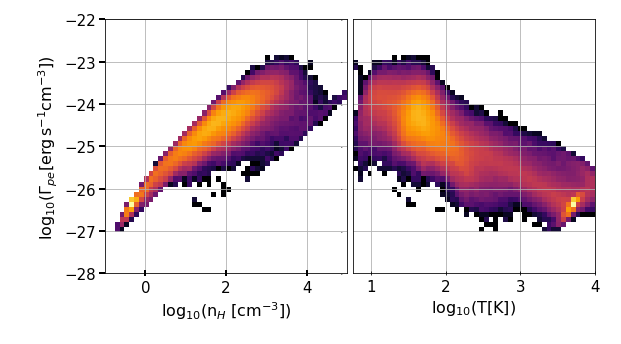

In [23]:
xsize = 8
ysize = 4.3

nfigs_x = 2
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.15
wpad = 0.13
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

##########################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(nH), np.log10(HH18), bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 5.0],[-28, -22]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("log$_{10} (\Gamma_{pe}[\mathrm{erg \, s}^{-1} \mathrm{cm}^{-3}])$", fontsize=16)
ax.set_xlabel("log$_{10}$(n$_{H}$ [cm$^{-3}$])", fontsize=16)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(temp), np.log10(HH18), bins=50, norm=LogNorm(), cmap="inferno", range=[[0.75, 4.0],[-28, -22]])

ax.grid("on")

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', labelsize=15)
#ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)

ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(T[K])", fontsize=16)

ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

#fig.savefig("/Users/juan/Dropbox/Talks/Conf, Workshops & Schools/2018/Group Meeting/IM18_piecewise.pdf", format="pdf")

fig.show()




In [ ]:
xsize = 8
ysize = 4.3

nfigs_x = 2
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.15
wpad = 0.13
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

##########################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(nH[0:200]), np.log10(HH18old), bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 5.0],[-28, -22]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("log$_{10} (\Gamma_{pe}[\mathrm{erg \, s}^{-1} \mathrm{cm}^{-3}])$", fontsize=16)
ax.set_xlabel("log$_{10}$(n$_{H}$ [cm$^{-3}$])", fontsize=16)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(temp[0:200]), np.log10(HH18old), bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[-28, -22]])

ax.grid("on")

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', labelsize=15)
#ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)

ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(T[K])", fontsize=16)

ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

#fig.savefig("/Users/juan/Dropbox/Talks/Conf, Workshops & Schools/2018/Group Meeting/IM18_old.pdf", format="pdf")

fig.show()




In [ ]:
xsize = 8
ysize = 4.3

nfigs_x = 2
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.15
wpad = 0.13
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

##########################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(nH[0:200]), diff, bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 5.0],[np.min(diff), np.max(diff)]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("log$_{10} (\Gamma_{pe}[\mathrm{erg \, s}^{-1} \mathrm{cm}^{-3}])$", fontsize=16)
ax.set_xlabel("log$_{10}$(n$_{H}$ [cm$^{-3}$])", fontsize=16)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(temp[0:200]), diff, bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[np.min(diff), np.max(diff)]])

ax.grid("on")

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', labelsize=15)
#ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)

ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(T[K])", fontsize=16)

ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

#fig.savefig("/Users/juan/Dropbox/Talks/Conf, Workshops & Schools/2018/Group Meeting/IM18_ratio.pdf", format="pdf")

fig.show()





---

In [2]:
Heat_IM18 = np.zeros_like(nH)
for i in range(10):
    Heat_IM18[i] = get_Gamma_tot(Gtot[i], temp[i], new_ne[i])

NameError: name 'np' is not defined

In [39]:
Heat_IM18 = np.zeros_like(nH)
for i in range(len(nH)):
    Heat_IM18[i] = get_Gamma_tot(Gtot[i], temp[i], new_ne[i])

In [40]:
HH18 = Heat_IM18*nH

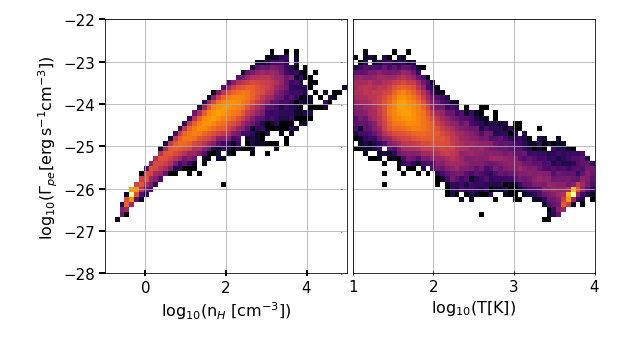

In [55]:
xsize = 8
ysize = 4.3

nfigs_x = 2
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.15
wpad = 0.13
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

##########################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(nH), np.log10(HH18), bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 5.0],[-28, -22]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("log$_{10} (\Gamma_{pe}[\mathrm{erg \, s}^{-1} \mathrm{cm}^{-3}])$", fontsize=16)
ax.set_xlabel("log$_{10}$(n$_{H}$ [cm$^{-3}$])", fontsize=16)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(temp), np.log10(HH18), bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[-28, -22]])

ax.grid("on")

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', labelsize=15)
#ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)

ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(T[K])", fontsize=16)

ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

fig.savefig("/Users/juan/Dropbox/Talks/Conf, Workshops & Schools/2018/Group Meeting/IM18_heating.pdf", format="pdf")

fig.show()



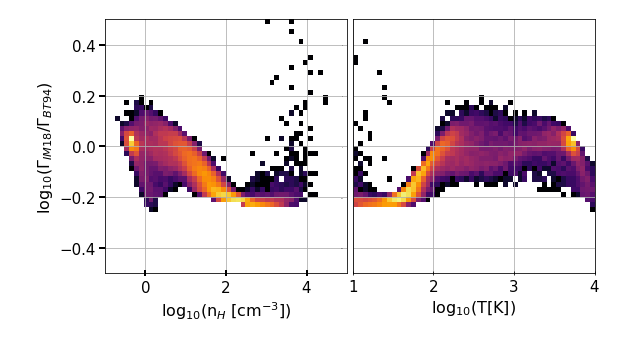

In [56]:
xsize = 8
ysize = 4.3

nfigs_x = 2
nfigs_y = 1

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.15
wpad = 0.13
wwpad = 0.01

xs_panel = 0.84 / nfigs_x 
ys_panel = 0.82 / nfigs_y 

##########################################################################################################
############################             n          #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

#ax.text(0.18, 0.955, "5 AA", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#cax = ax.hist2d(np.log10(nH), np.log10(HH18/Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno", range=[[-1, 5.0],[-28, -22]])
cax = ax.hist2d(np.log10(nH), np.log10(HH18/Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno",range=[[-1, 5.0],[-0.5, 0.5]])

ax.grid("on")
ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off
ax.set_ylabel("log$_{10} (\Gamma_{IM18} / \Gamma_{BT94})$", fontsize=16)
ax.set_xlabel("log$_{10}$(n$_{H}$ [cm$^{-3}$])", fontsize=16)
ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

ax = fig.add_axes([wpad + ii*(xs_panel+wwpad), hpad + jj*ys_panel, xs_panel, ys_panel])

cax = ax.hist2d(np.log10(temp), np.log10(HH18/Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno", range=[[1, 4.0],[-0.5, 0.5]])
#cax = ax.hist2d(np.log10(temp), np.log10(HH18/Heat_BT94), bins=50, norm=LogNorm(), cmap="inferno")

ax.grid("on")

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on', labelsize=15)
#ax.tick_params(axis='both', which='major', length=6, width=2, labelsize=15)

ax.tick_params(axis='x', which='both', bottom='on', top='off', direction= 'inout',labelbottom='on') # labels along the bottom edge are off

ax.set_xlabel("log$_{10}$(T[K])", fontsize=16)

ax.tick_params(axis='y', left="off", which='major', length=6, width=2, labelsize=0)

fig.savefig("/Users/juan/Dropbox/Talks/Conf, Workshops & Schools/2018/Group Meeting/heating_ratios.pdf", format="pdf")

fig.show()




In [110]:
cmm = ((box["nH"] >1.0e3)&(box["nH"] <1.0e5))

In [111]:
cmmtrue = np.argwhere(cmm==True)

In [123]:
np.random.seed(1)
#np.random.seed(2)
ncells = len(cmmtrue)
percent = 2.0

n5             = np.int(ncells * percent/100.)
rand_indexCMM  = np.random.randint(0, ncells, n5)

In [124]:
tempCMM = np.array(box["temp"][cmmtrue[rand_indexCMM]])
nHCMM   = np.array(box["nH"]  [cmmtrue[rand_indexCMM]])
neCMM   = np.array(box["ne"]  [cmmtrue[rand_indexCMM]])
xeCMM   = np.array(box["xe"]  [cmmtrue[rand_indexCMM]])
xH2CMM  = np.array(box["xH2"] [cmmtrue[rand_indexCMM]])
AvCMM   = np.array(box["cdto"][cmmtrue[rand_indexCMM]])
fH2shieldCMM = np.array(box["cdh2"][cmmtrue[rand_indexCMM]])

GeffCMM = 1.7 * np.exp(-2.5*AvCMM)

In [125]:
NH2CMM = np.zeros_like(AvCMM)
G_CRCMM = np.zeros_like(AvCMM)

for ii in range(len(AvCMM)):
    NH2CMM[ii]   = fz.get_NH2(fH2shieldCMM[ii], tempCMM[ii])
    G_CRCMM[ii]  = fz.get_G_CR(NH2CMM[ii])

In [126]:
zetaCMM = np.zeros_like(NH2CMM)
new_neCMM = np.zeros_like(NH2CMM)
new_xeCMM = np.zeros_like(NH2CMM)
for i in range(len(zetaCMM)):
    zetaCMM[i]  = fz.get_zeta(NH2CMM[i])
    new_neCMM[i], new_xeCMM[i] = fz.compute_new_xe([nHCMM[i], 0.], [xeCMM[i],0], xH2CMM[i], zetaCMM[i])

In [127]:
GtotCMM = GeffCMM + G_CRCMM

In [122]:
len(GtotCMM)

36196

In [128]:
#Heat_IM18CMM = np.zeros_like(nHCMM)
progress = 0
ncells = len(nHCMM)
#ncells = 100

for i in range(ncells):
    if ((i+1.)/ncells*100. % 10 == 0):
        print("Progress = %i "%((i+1.)/ncells*100.))
    Heat_IM18CMM[i] = get_Gamma_tot(GtotCMM[i], tempCMM[i], new_neCMM[i])

Progress = 100 


In [129]:
HIM18CMM = Heat_IM18CMM*nHCMM

In [139]:
np.shape(tempCMM[:,0])

(3619,)

In [136]:
tempCMM[:,0]

array([ 32.07401654,  31.22668022,  13.49056655, ...,  12.01991769,
        27.90409323,  11.96731082])

In [132]:
np.shape(nHCMM)

(3619, 1)

In [140]:
ntot = np.concatenate([nH, nHCMM[:,0]])

In [142]:
ntot = np.concatenate([nH, nHCMM[:,0]])
Ttot = np.concatenate([temp, tempCMM[:,0]])
HIM18 = np.concatenate([HH18, HIM18CMM[:,0]])